In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('E:/Рабочий стол С/python_projects/carpov_courses_python')

from library.visualization.visual_preset import set_visualization_settings
set_visualization_settings()

Мы будем работать с данными агрегатора такси [Sigma Cabs](https://www.kaggle.com/datasets/arashnic/taxi-pricing-with-mobility-analytics). В зависимости от характеристик поездки требуется предсказать один из трех типов повышенного ценообразования: [1, 2, 3]. Таким образом, это поможет компании оптимально мэтчить такси и клиентов. 

In [3]:
df = pd.read_csv('../data/sigma_cabs.csv')
df.shape

(131662, 14)

In [4]:
# Занесем индекс колонку
df = df.set_index('Trip_ID')
df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
Trip_ID,,,,,,,,,,,,,
T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


Описание признаков:

1. **Trip_ID**: ID for TRIP
2. **Trip_Distance**: The distance for the trip requested by the customer
3. **TypeofCab**: Category of the cab requested by the customer
4. **CustomerSinceMonths**: Customer using cab services since n months; 0 month means current month
5. **LifeStyleIndex**: Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour
6. **ConfidenceLifeStyle_Index**: Category showing confidence on the index mentioned above
7. **Destination_Type**: Sigma Cabs divides any destination in one of the 14 categories.
8. **Customer_Rating**: Average of life time ratings of the customer till date
9. **CancellationLast1Month**: Number of trips cancelled by the customer in last 1 month
10. **Var1**, **Var2** and **Var3**: Continuous variables masked by the company. Can be used for modelling purposes
11. **Gender**: Gender of the customer

**SurgePricingType**: Target (can be of 3 types)


### EDA 
Заполните пропуски в вещественных признаках медианой, а в категориальных - самым популярным классом. Изобразите марицу корреляций и выведите топ5 пар самых коррелированных признаков.

Так как в сумме уникальных значений различных категориальных признаков окажется не супер-много, примените `One-Hot-Encoding` для них. Не забудьте в методе `pd.get_dummies` указать параметр `drop_first=True`.

In [5]:
### Your code is here

df.isna().sum()

Trip_Distance                      0
Type_of_Cab                    20210
Customer_Since_Months           5920
Life_Style_Index               20193
Confidence_Life_Style_Index    20193
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           71030
Var2                               0
Var3                               0
Gender                             0
Surge_Pricing_Type                 0
dtype: int64

### Training

In [6]:
df.dtypes

Trip_Distance                  float64
Type_of_Cab                     object
Customer_Since_Months          float64
Life_Style_Index               float64
Confidence_Life_Style_Index     object
Destination_Type                object
Customer_Rating                float64
Cancellation_Last_1Month         int64
Var1                           float64
Var2                             int64
Var3                             int64
Gender                          object
Surge_Pricing_Type               int64
dtype: object

In [7]:
from library.data_processing.feature_to_type import numeric_categorical_columns
numeric_columns, categorical_columns = numeric_categorical_columns(df)

In [8]:
for col in numeric_columns:
    median = df[col].median()
    df[col] = df[col].fillna(median)

In [9]:
### Заполнение пропусков категориальных признаков самым популярным
for col in categorical_columns:
    most_recent = df.groupby(col).size().sort_values().index[-1]
    df[col] = df[col].fillna(most_recent)

In [10]:
df[categorical_columns]

,Type_of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender
Trip_ID,,,,
T0005689460,B,A,A,Female
T0005689461,B,B,A,Male
T0005689464,B,B,E,Male
T0005689465,C,B,A,Male
T0005689467,C,B,A,Male
...,...,...,...,...
T0005908509,D,A,A,Male
T0005908510,C,C,A,Male
T0005908512,C,B,A,Female


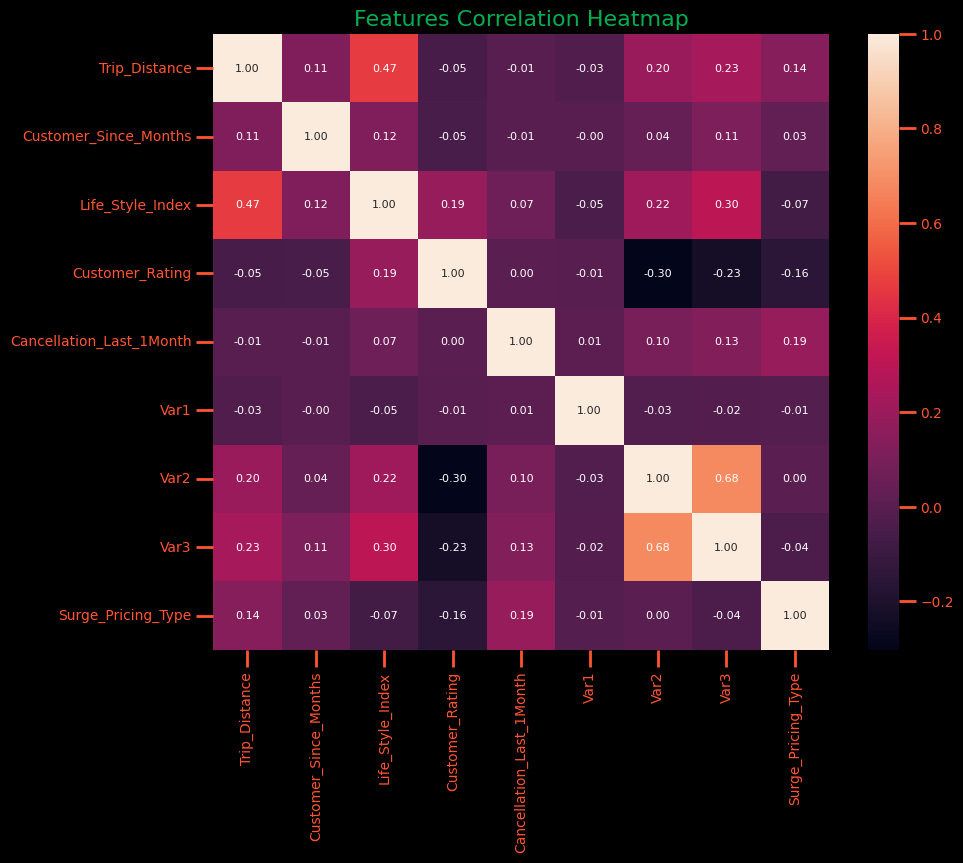

In [11]:
from library.visualization.HeatMap import plot_correlation_heatmap

plot_correlation_heatmap(df)

In [12]:
from library.data_processing.correlations import print_top_abs_correlations
corr = print_top_abs_correlations(df[numeric_columns])


Top Absolute Correlations:
          Feature 1         Feature 2  Correlation
0              Var2              Var3     0.683437
1     Trip_Distance  Life_Style_Index     0.468332
2  Life_Style_Index              Var3     0.303324
3   Customer_Rating              Var2     0.302968
4     Trip_Distance              Var3     0.231706


In [13]:
df[numeric_columns].describe()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type
count,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000
mean,44.200909,6.015912,2.801448,2.849458,0.782838,62.474883,51.202800,75.099019,2.155747
std,25.522882,3.544411,0.207765,0.980675,1.037559,14.893324,4.986142,11.578278,0.738164
min,0.310000,0.000000,1.596380,0.001250,0.000000,30.000000,40.000000,52.000000,1.000000
25%,24.580000,3.000000,2.687952,2.152500,0.000000,61.000000,48.000000,67.000000,2.000000
50%,38.200000,6.000000,2.798050,2.895000,0.000000,61.000000,50.000000,74.000000,2.000000
75%,60.730000,10.000000,2.912815,3.582500,1.000000,61.000000,54.000000,82.000000,3.000000
max,109.230000,10.000000,4.875110,5.000000,8.000000,210.000000,124.000000,206.000000,3.000000


In [14]:
df[categorical_columns].describe(include=object)

,Type_of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender
count,131662,131662,131662,131662
unique,5,3,14,2
top,B,B,A,Male
freq,51346,60548,77597,93900


In [15]:
for col in categorical_columns:
    one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True)
    one_hot.replace({False: 0, True: 1}, inplace=True)
    df = pd.concat((df.drop(col, axis=1), one_hot), axis=1)

In [16]:
df

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type,Type_of_Cab_B,...,Destination_Type_F,Destination_Type_G,Destination_Type_H,Destination_Type_I,Destination_Type_J,Destination_Type_K,Destination_Type_L,Destination_Type_M,Destination_Type_N,Gender_Male
Trip_ID,,,,,,,,,,,,,,,,,,,,,
T0005689460,6.77,1.0,2.42769,3.90500,0,40.0,46,60,2,1,...,0,0,0,0,0,0,0,0,0,0
T0005689461,29.47,10.0,2.78245,3.45000,0,38.0,56,78,2,1,...,0,0,0,0,0,0,0,0,0,1
T0005689464,41.58,10.0,2.79805,3.50125,2,61.0,56,77,2,1,...,0,0,0,0,0,0,0,0,0,1
T0005689465,61.56,10.0,2.79805,3.45375,0,61.0,52,74,3,0,...,0,0,0,0,0,0,0,0,0,1
T0005689467,54.95,10.0,3.03453,3.40250,4,51.0,49,102,2,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T0005908509,11.72,1.0,2.74229,3.28500,0,61.0,47,76,3,0,...,0,0,0,0,0,0,0,0,0,1
T0005908510,74.81,7.0,2.81059,0.44500,0,61.0,63,88,2,0,...,0,0,0,0,0,0,0,0,0,1
T0005908512,40.17,10.0,2.99565,3.33625,0,61.0,48,75,2,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
np.random.seed(2022)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [18]:
X = df.drop('Surge_Pricing_Type', axis=1)
Y = df['Surge_Pricing_Type']

In [19]:
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

**Задание 1.** Обучите One-vs-Rest Logreg. Не забудьте в шаг добавить стандартизацию данных (через `StandardScaler`) Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg. Здесь и далее округляйте до 3 знака после запятой.

Чтобы отдельно и долго не вычислять метрики, можно воспользоваться `classification_report` из `sklearn.metrics`!

In [20]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

### Your code is here

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("one_vs_all", OneVsRestClassifier(LogisticRegression(penalty='l2')))
])

pipe.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression()))])

In [21]:
print(pipe.classes_)
print(pipe.predict(X_test.head(1)))

print(pipe.decision_function(X_test.head(1)))

print(pipe.predict_proba(X_test.head(1)))

[1 2 3]
[3]
[[-0.95512036 -0.98969627 -0.49804367]]
[[0.2997924  0.29236474 0.40784286]]


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"""Precision равно: {precision_score(Y_test,
                                            pipe.predict(X_test),
                                            average='macro'):.3f}""")

print(f"""Recall равно: {recall_score(Y_test,
                                      pipe.predict(X_test),
                                      average='macro'):.3f}""")

print(f"""F-мера равно: {f1_score(Y_test,
                                  pipe.predict(X_test),
                                  average='macro'):.3f}""")

Precision равно: 0.700
Recall равно: 0.649
F-мера равно: 0.662


In [23]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, pipe.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.723     0.542     0.619      5372
           2      0.636     0.834     0.722     11349
           3      0.741     0.571     0.645      9612

    accuracy                          0.679     26333
   macro avg      0.700     0.649     0.662     26333
weighted avg      0.692     0.679     0.673     26333



In [24]:
pipe.classes_[0]

1

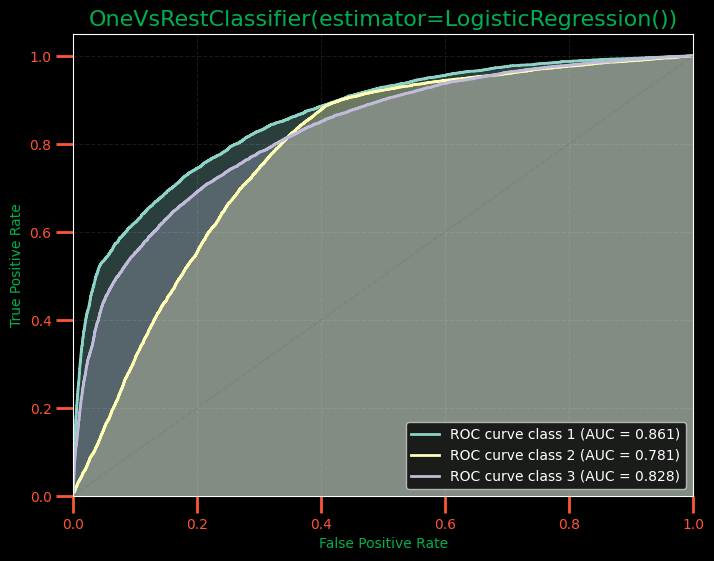

[0.8610793356154143, 0.7807548247075495, 0.8275784425917576]

In [25]:
from library.visualization.ROC_AUC import MultiClassROCCurve
ROC_plotter = MultiClassROCCurve(pipe, X_test, Y_test)
ROC_plotter.plot(title=pipe.steps[1][1])

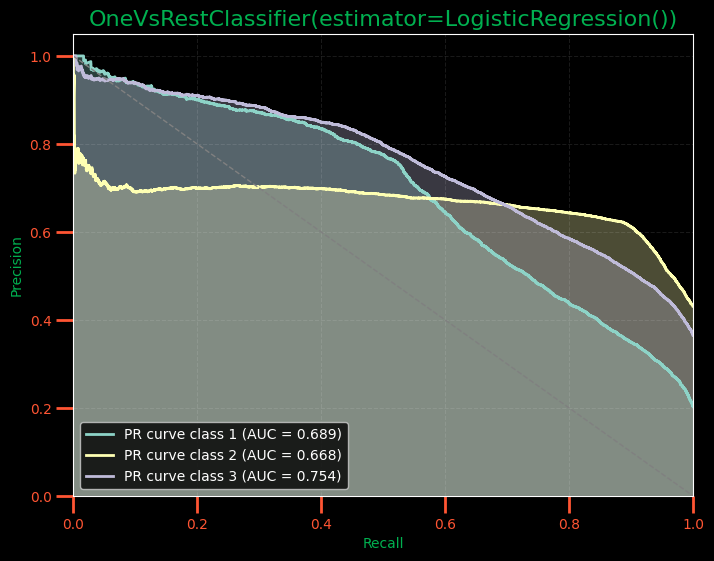

[0.689167577790321, 0.6675713281560943, 0.7539089496289558]

In [26]:
from library.visualization.PR_AUC import MultiClassPRCurve
PR_plotter = MultiClassPRCurve(pipe, X_test, Y_test)
PR_plotter.plot(title=pipe.steps[1][1])

In [27]:
### Hinge

from sklearn.svm import LinearSVC

pipe_hinge = Pipeline([
    ("scaler", StandardScaler()),
    ("one_vs_all", OneVsRestClassifier(LinearSVC(penalty='l2')))
])

pipe_hinge.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all', OneVsRestClassifier(estimator=LinearSVC()))])

In [28]:
print(classification_report(Y_test, pipe_hinge.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.704     0.548     0.616      5372
           2      0.631     0.853     0.725     11349
           3      0.755     0.535     0.626      9612

    accuracy                          0.675     26333
   macro avg      0.697     0.645     0.656     26333
weighted avg      0.691     0.675     0.667     26333



Вероятности находятся в диапазоне от 0 до 1.


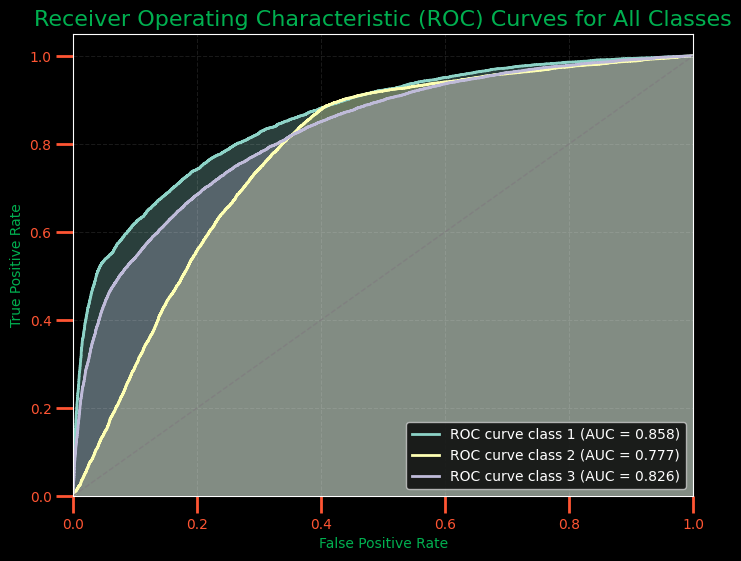

[0.8581186728975767, 0.7773276368644073, 0.8258610139434831]

In [29]:
ROC_plotter_hinge = MultiClassROCCurve(pipe_hinge, X_test, Y_test)
ROC_plotter_hinge.plot()

Вероятности находятся в диапазоне от 0 до 1.


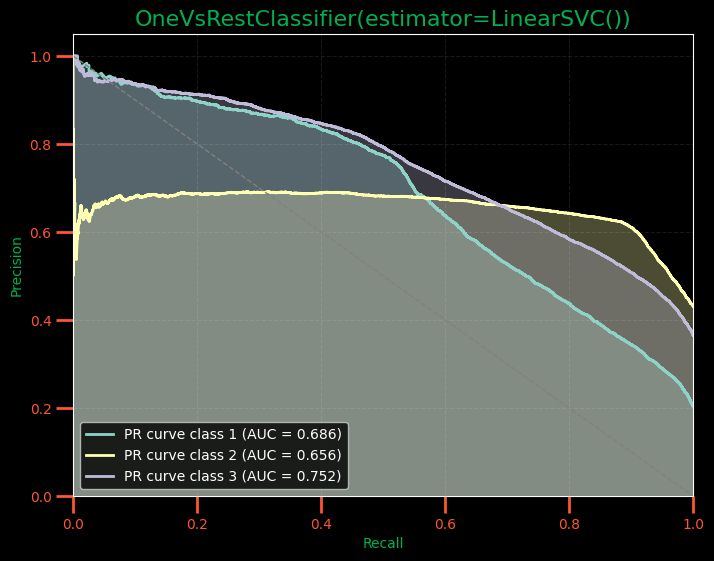

[0.6855550354897264, 0.6558968096805307, 0.7517225357011921]

In [30]:
PR_plotter_hinge = MultiClassPRCurve(pipe_hinge, X_test, Y_test)
PR_plotter_hinge.plot(title=pipe_hinge.steps[1][1])

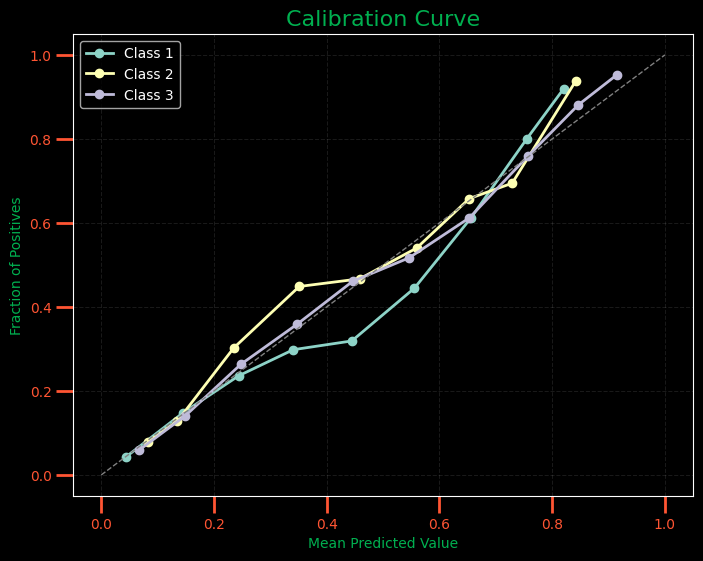

In [31]:
from library.visualization.CalibrationCurve import plot_calibration_curve
plot_calibration_curve(pipe, X_test, Y_test)

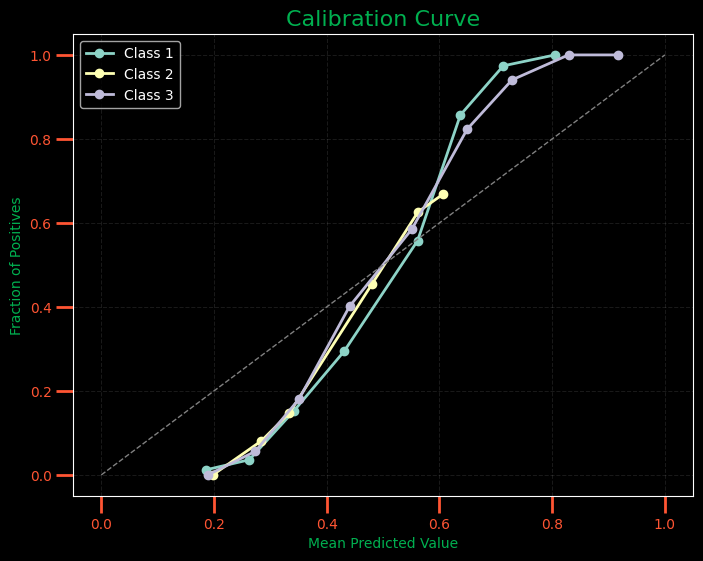

In [32]:
plot_calibration_curve(pipe_hinge, X_test, Y_test)

In [33]:
from library.data_processing.calibration_probs import PlattScalingCalibrator
calibrator = PlattScalingCalibrator(pipe_hinge)
pipe_hinge_calibrated = calibrator.fit(X_train, Y_train, method='isotonic')

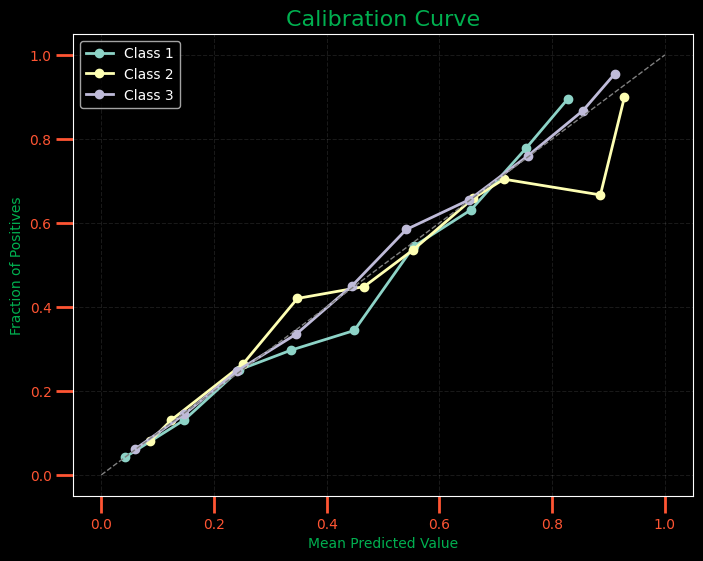

In [34]:
plot_calibration_curve(pipe_hinge_calibrated, X_test, Y_test)

In [35]:
pipe_hinge.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('one_vs_all', OneVsRestClassifier(estimator=LinearSVC()))],
 'verbose': False,
 'scaler': StandardScaler(),
 'one_vs_all': OneVsRestClassifier(estimator=LinearSVC()),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'one_vs_all__estimator__C': 1.0,
 'one_vs_all__estimator__class_weight': None,
 'one_vs_all__estimator__dual': 'warn',
 'one_vs_all__estimator__fit_intercept': True,
 'one_vs_all__estimator__intercept_scaling': 1,
 'one_vs_all__estimator__loss': 'squared_hinge',
 'one_vs_all__estimator__max_iter': 1000,
 'one_vs_all__estimator__multi_class': 'ovr',
 'one_vs_all__estimator__penalty': 'l2',
 'one_vs_all__estimator__random_state': None,
 'one_vs_all__estimator__tol': 0.0001,
 'one_vs_all__estimator__verbose': 0,
 'one_vs_all__estimator': LinearSVC(),
 'one_vs_all__n_jobs': None,
 'one_vs_all__verbose': 0}

In [36]:
df.groupby('Surge_Pricing_Type').size()

Surge_Pricing_Type
1    27214
2    56728
3    47720
dtype: int64

Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()` из предложенных. Для лучшего набора гиперпараметров посчитайте те же самые метрики. Валидировать параметры необходимо по `accuracy`. В этот раз проведем настояющую процедуру Кросс-Валидации! 

Для этого в метод `fit` передадим тренировочную часть наших данных, в параметр `cv` ничего не будем передавать (по дефолту 5-fold Кросс-Валидация будет проведена), а итоговые метрики замерим на тесте!

In [37]:
param_grid = {'one_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
              'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1]}

In [38]:
pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression()))])

In [39]:
### Your code is here

from sklearn.model_selection import GridSearchCV

grid_search_LR = GridSearchCV(pipe,
                              param_grid,
                              cv=5,
                              scoring='accuracy')

grid_search_LR.fit(X_train, Y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('one_vs_all',
                                        OneVsRestClassifier(estimator=LogisticRegression()))]),
             param_grid={'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1],
                         'one_vs_all__estimator__penalty': ['l1', 'l2',
                                                            'elasticnet']},
             scoring='accuracy')

In [40]:
# Вывод лучших параметров и оценки
print("Лучшие параметры:", grid_search_LR.best_params_)
print("Лучшая оценка:", grid_search_LR.best_score_)

Лучшие параметры: {'one_vs_all__estimator__C': 0.001, 'one_vs_all__estimator__penalty': 'l2'}
Лучшая оценка: 0.6806292815123397


In [41]:
pipe_LR = grid_search_LR.best_estimator_

In [42]:
pipe_LR.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('one_vs_all', OneVsRestClassifier(estimator=LogisticRegression(C=0.001)))],
 'verbose': False,
 'scaler': StandardScaler(),
 'one_vs_all': OneVsRestClassifier(estimator=LogisticRegression(C=0.001)),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'one_vs_all__estimator__C': 0.001,
 'one_vs_all__estimator__class_weight': None,
 'one_vs_all__estimator__dual': False,
 'one_vs_all__estimator__fit_intercept': True,
 'one_vs_all__estimator__intercept_scaling': 1,
 'one_vs_all__estimator__l1_ratio': None,
 'one_vs_all__estimator__max_iter': 100,
 'one_vs_all__estimator__multi_class': 'auto',
 'one_vs_all__estimator__n_jobs': None,
 'one_vs_all__estimator__penalty': 'l2',
 'one_vs_all__estimator__random_state': None,
 'one_vs_all__estimator__solver': 'lbfgs',
 'one_vs_all__estimator__tol': 0.0001,
 'one_vs_all__estimator__verbose': 0,
 'one_vs_all__estimator__warm_start': False,
 'one_vs_all__estimator'

In [43]:
print(classification_report(Y_test, pipe_LR.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.742     0.534     0.621      5372
           2      0.635     0.839     0.723     11349
           3      0.742     0.576     0.649      9612

    accuracy                          0.681     26333
   macro avg      0.706     0.650     0.664     26333
weighted avg      0.696     0.681     0.675     26333



Изобразите три калибровочные кривые для Logistic Classifier: 0-vs-rest, 1-vs-rest, 2-vs-rest. Хорошо ли откалиброван обученный классификатор? 

Заметьте, что `predict_proba` возвращает список из вероятностей для всех наших классов!

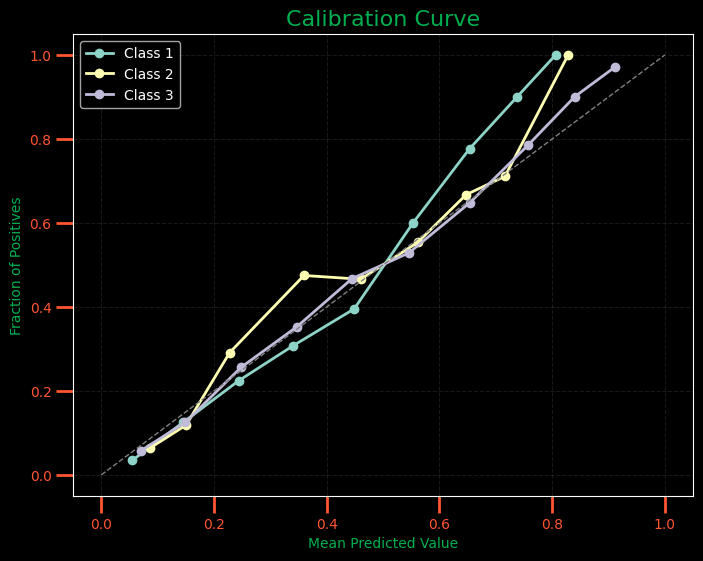

In [44]:
### Your code is here

plot_calibration_curve(pipe_LR, X_test, Y_test)


**Задание 2.** Обучите логистическую регрессию с гиперпараметрами из первого задания на полиномиальных признаках до 4 степени. Сравните метрики с первым заданием.


Пример: Пусть у нас был единственный признак 

$$
d_j = [1, 2, 3, 4]
$$

Тогда полиномиальные признаки до 4 степени от такого будут иметь вид:

$$
d_j^1 = [1, 2, 3, 4]
$$

$$
d_j^2 = [1, 4, 9, 16]
$$

$$
d_j^3 = [1, 8, 27, 64]
$$

$$
d_j^4 = [1, 16, 81, 256]
$$

P.S. Бинарные колонки нет смысла возводить в какие-то степени, поэтому возьмем исключительно вещественные из базовых. 

Для этого можно воспользоваться классическим циклом (или уроком из занятия про `Sberbank Housing Market`). Положите модифицированный датасет в переменную `X_polinomial`!

P.S.S Зачастую еще, создаваю полиномиальные фичи, учитывают "пересечения" признаков, то есть, например, из векторов признаков $d_j, d_i$ генерируют не просто новые степени $d_j^2, d_i^2, d_j^3, d_i^3...$, а еще и признаки вида $d_j \cdot d_i, d_j^2 \cdot d_i, d_j \cdot d_i^2...$, но здесь ограничьтесь просто степенями!

In [45]:
### Создание полиномиальных признаков

X_polinomial = X.copy()


### Your code is here

for col in numeric_columns:
    if col != 'Surge_Pricing_Type':
        for power in [2, 3, 4]:

            to_add = (X_polinomial[col]**power).to_frame().rename({col:f"{col}_{power}"}, axis=1)
            X_polinomial = pd.concat((X_polinomial, to_add), axis=1)

X_polinomial

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Type_of_Cab_B,Type_of_Cab_C,...,Cancellation_Last_1Month_4,Var1_2,Var1_3,Var1_4,Var2_2,Var2_3,Var2_4,Var3_2,Var3_3,Var3_4
Trip_ID,,,,,,,,,,,,,,,,,,,,,
T0005689460,6.77,1.0,2.42769,3.90500,0,40.0,46,60,1,0,...,0,1600.0,64000.0,2560000.0,2116,97336,4477456,3600,216000,12960000
T0005689461,29.47,10.0,2.78245,3.45000,0,38.0,56,78,1,0,...,0,1444.0,54872.0,2085136.0,3136,175616,9834496,6084,474552,37015056
T0005689464,41.58,10.0,2.79805,3.50125,2,61.0,56,77,1,0,...,16,3721.0,226981.0,13845841.0,3136,175616,9834496,5929,456533,35153041
T0005689465,61.56,10.0,2.79805,3.45375,0,61.0,52,74,0,1,...,0,3721.0,226981.0,13845841.0,2704,140608,7311616,5476,405224,29986576
T0005689467,54.95,10.0,3.03453,3.40250,4,51.0,49,102,0,1,...,256,2601.0,132651.0,6765201.0,2401,117649,5764801,10404,1061208,108243216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T0005908509,11.72,1.0,2.74229,3.28500,0,61.0,47,76,0,0,...,0,3721.0,226981.0,13845841.0,2209,103823,4879681,5776,438976,33362176
T0005908510,74.81,7.0,2.81059,0.44500,0,61.0,63,88,0,1,...,0,3721.0,226981.0,13845841.0,3969,250047,15752961,7744,681472,59969536
T0005908512,40.17,10.0,2.99565,3.33625,0,61.0,48,75,0,1,...,0,3721.0,226981.0,13845841.0,2304,110592,5308416,5625,421875,31640625


In [46]:
X_pol_train, X_pol_test, y_train, y_test  = train_test_split(X_polinomial, Y, 
                                                             test_size=0.2, 
                                                             shuffle=True, 
                                                             random_state=2022)

In [47]:
### Your code is here
pipe_LR_pol = grid_search_LR.best_estimator_
pipe_LR_pol.fit(X_pol_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression(C=0.001)))])

In [48]:
print(classification_report(y_test, pipe_LR_pol.predict(X_pol_test), digits=3))

              precision    recall  f1-score   support

           1      0.748     0.532     0.622      5372
           2      0.636     0.837     0.723     11349
           3      0.741     0.584     0.653      9612

    accuracy                          0.682     26333
   macro avg      0.708     0.651     0.666     26333
weighted avg      0.697     0.682     0.677     26333



По аналогии с первым заданием изобразите три калибровочные кривые. Стало ли лучше?

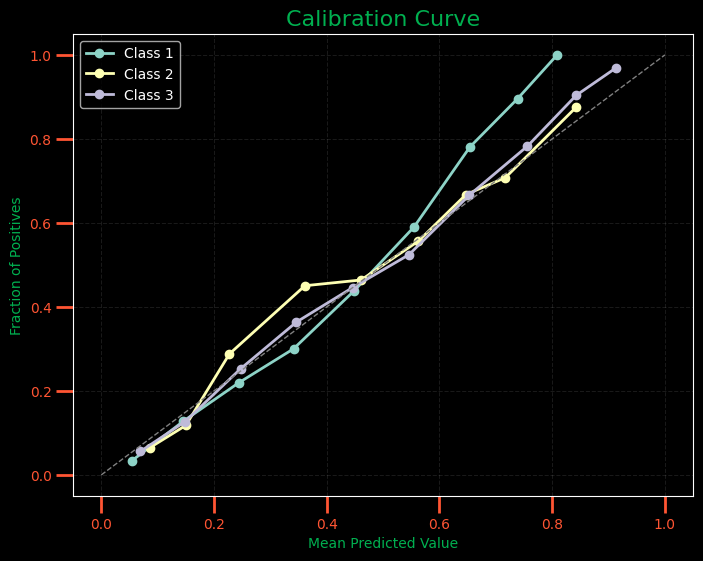

In [49]:
### Your code is here
plot_calibration_curve(pipe_LR_pol, X_pol_test, Y_test)


**Задание 3.** Обучите на датасете без полиномиальных признаков One-vs-One `SGDClassifier` из `sklearn.linear_model`, который использует стохастический градиентный спуск (узнаете о нем позже) и может обучать как `SVM`, так и, например, `LogReg`, если указать в качестве параметра `loss` либо `hinge`, либо `log` соответственно!

Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg.

In [51]:
X_train, X_test, y_train, y_test  = train_test_split(X, Y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

In [56]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

### Your code is here

pipe_all_all = Pipeline([
    ('scaler', StandardScaler()),
    ('one_vs_one', OneVsOneClassifier(SGDClassifier(loss='log_loss')))
])

pipe_all_all.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_one',
                 OneVsOneClassifier(estimator=SGDClassifier(loss='log_loss')))])

Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()`. При этом переберите всевозможные функции потерь. Таким образом, при `loss = 'hinge'`, мы обучим SVM, при `loss = 'log'` мы обучим логистическую регрессию и т.д.

Используйте прием с Кросс-Валидацией при подборе параметров, как ранее, а также замерьте метрики на тесте.

In [57]:
param_grid = {'one_vs_one__estimator__loss': ['hinge', 'log', 'modified_huber'],
              'one_vs_one__estimator__penalty': ['l1', 'l2'],
              'one_vs_one__estimator__alpha': [0.001, 0.01, 0.1]}

In [58]:
### Your code is here

grid_search_all_all = GridSearchCV(pipe_all_all,
                              param_grid,
                              cv=5,
                              scoring='accuracy')

grid_search_all_all.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('one_vs_one',
                                        OneVsOneClassifier(estimator=SGDClassifier(loss='log_loss')))]),
             param_grid={'one_vs_one__estimator__alpha': [0.001, 0.01, 0.1],
                         'one_vs_one__estimator__loss': ['hinge', 'log',
                                                         'modified_huber'],
                         'one_vs_one__estimator__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [59]:
best_model_all_all = grid_search_all_all.best_estimator_

In [60]:
print(classification_report(y_test, best_model_all_all.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.746     0.529     0.619      5372
           2      0.632     0.846     0.723     11349
           3      0.745     0.568     0.645      9612

    accuracy                          0.680     26333
   macro avg      0.708     0.648     0.662     26333
weighted avg      0.697     0.680     0.673     26333



Вероятности находятся в диапазоне от 0 до 1.


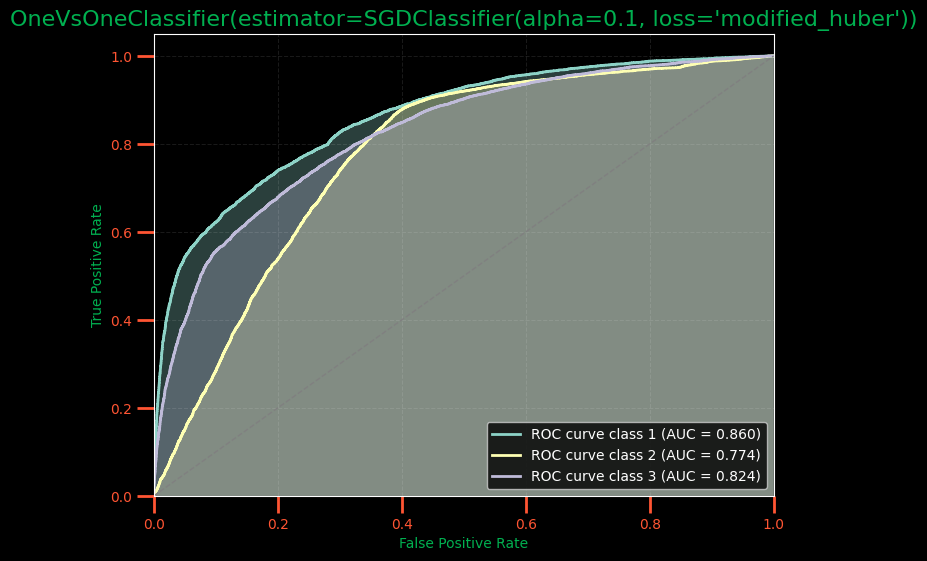

[0.859952335690759, 0.7740967108828911, 0.823749675931619]

In [61]:
ROC_plotter = MultiClassROCCurve(best_model_all_all, X_test, Y_test)
ROC_plotter.plot(title=best_model_all_all.steps[1][1])

Вероятности находятся в диапазоне от 0 до 1.


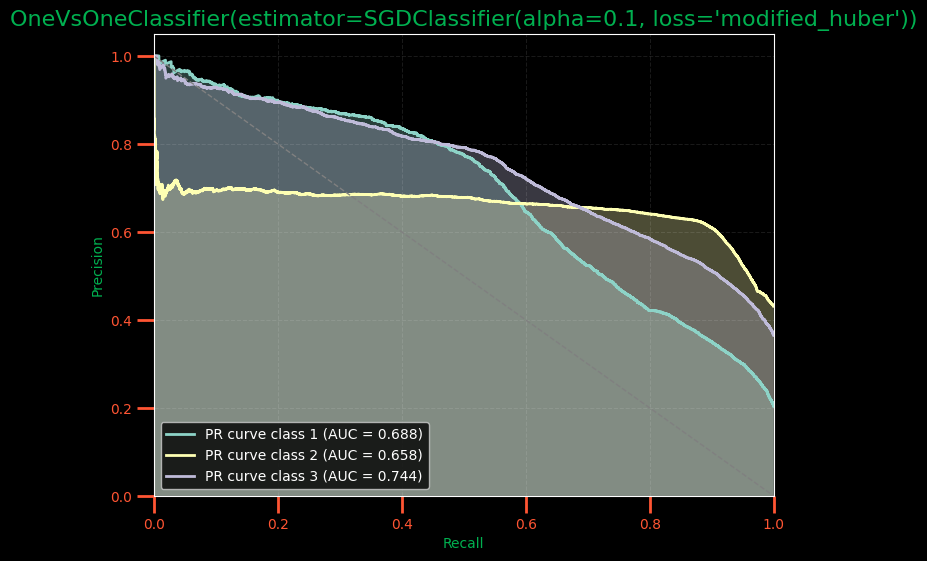

[0.6880441788646883, 0.6580772466582261, 0.743569676538249]

In [62]:
PR_plotter_hinge = MultiClassPRCurve(best_model_all_all, X_test, Y_test)
PR_plotter_hinge.plot(title=best_model_all_all.steps[1][1])

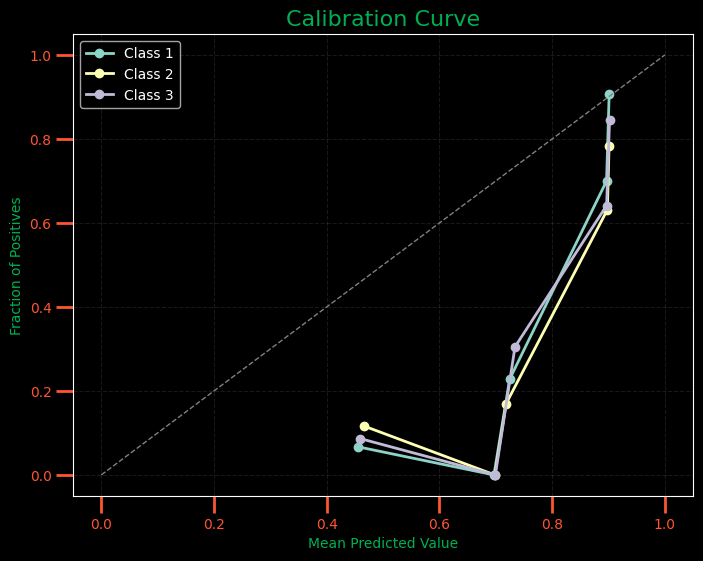

In [63]:
plot_calibration_curve(best_model_all_all, X_test, Y_test)

In [64]:
calibrator = PlattScalingCalibrator(best_model_all_all)
best_model_all_all_calibrated = calibrator.fit(X_train, Y_train, method='isotonic')

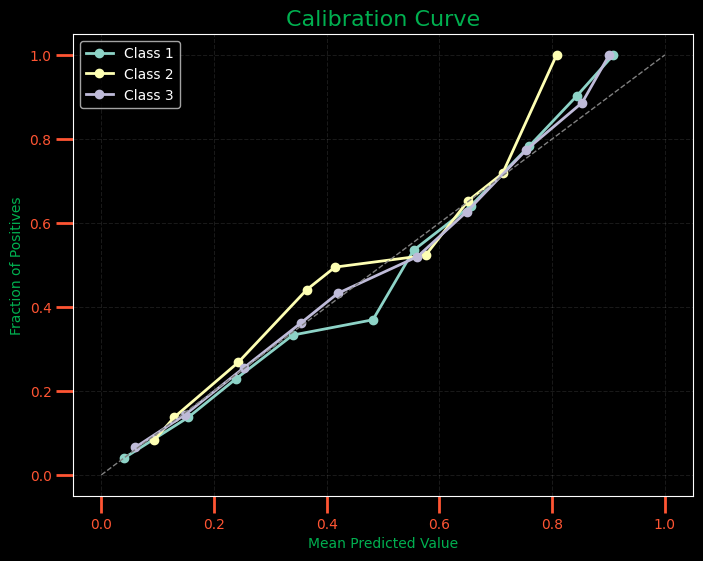

In [65]:
plot_calibration_curve(best_model_all_all_calibrated, X_test, Y_test)

In [66]:
print(classification_report(y_test, best_model_all_all_calibrated.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.748     0.528     0.619      5372
           2      0.632     0.847     0.724     11349
           3      0.745     0.568     0.645      9612

    accuracy                          0.680     26333
   macro avg      0.708     0.648     0.662     26333
weighted avg      0.697     0.680     0.673     26333



Можно ли однозначно сказать, какой подход оказался лучше: One-vs-Rest или One-vs-One?